# Evaluating Whisper on Aphasic Patients

In this notebook, we will be evaluating the `whisper-small-v3` model on the dataset that was provided by NUHS, using the Word Error Rate (WER) metric.

In [ ]:
import os

os.chdir('..')
os.getcwd()

### 1. Evaluating Noun Transcription Performance

Firstly, we will evaluate the noun transcription performance for all aphasic patients.

In [2]:
import os
import glob
import warnings

print(os.getcwd())
warnings.filterwarnings("ignore")


/Users/farhan/Desktop/itp/aphasic-evaluation


Based on Exploratory Data Analysis (EDA), each of the `.csv` files have the following columns:

1. Picture No.
2. Original (Assuming the actual target word)
3. Edited (The actual human transcription)
4. Marked

There are some pre-processing to be done for the transcription data for patients `al_e026` through `al_e137` and `al_e180`. However, the transcription data for `al_e155` and `al_e178` will not be used for evaluation for the following reasons:

1. Majority of rows go beyond the number of set columns
2. Too much missing data

#### Download the transcripts and audio files

In [3]:
import os
from tqdm import tqdm

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'aphasia-chatter-5a70166fc2f1.json'

In [32]:
# Download the transcripts
from google.cloud import storage

# Initialize the client
client = storage.Client()

# Define the bucket and blob (file) you want to download
bucket = client.get_bucket('speech-sit-bucket')  # Replace with your bucket name

# Specify the directory/prefix you want to retrieve files from
directory_prefix = 'transcripts/'  # Replace with the directory in your bucket (e.g., 'audio/')

# List all blobs (files) within the specified directory
transcripts = bucket.list_blobs(prefix=directory_prefix)

# Download directory
download_directory = 'samples/transcripts'

# Ensure the directory exists, create if necessary
if not os.path.exists(download_directory):
    os.makedirs(download_directory)

# Use tqdm to add a progress bar
for index, transcript in tqdm(enumerate(transcripts), desc="Downloading Files", unit=" files"):
    if index != 0:
        local_file_path = os.path.join(download_directory, os.path.basename(transcript.name))
        transcript.download_to_filename(local_file_path)

In [23]:
# Download the audio files

# Specify the directory/prefix you want to retrieve files from
directory_prefix = 'audio/'  # Replace with the directory in your bucket (e.g., 'audio/')

# List all blobs (files) within the specified directory
transcripts = bucket.list_blobs(prefix=directory_prefix)

# Download directory
download_directory = 'samples/audio'

# Ensure the directory exists, create if necessary
if not os.path.exists(download_directory):
    os.makedirs(download_directory)

# Use tqdm to add a progress bar
for index, transcript in tqdm(enumerate(transcripts), desc="Downloading Files", unit=" files"):
    if index != 0:
        local_file_path = os.path.join(download_directory, os.path.basename(transcript.name))
        transcript.download_to_filename(local_file_path)

In [34]:
import pandas as pd
from pathlib import Path

# Load all the transcripts into a dataframe and concat them
transcript_directories = "samples/transcripts/"
csv_files = glob.glob(transcript_directories + "*.csv")

# Remove al_e155_noun_transcript and al_e179_noun_transcript
csv_files = sorted([file for file in csv_files])

dfs = []

for file in csv_files:
    print(file)
    df = pd.read_csv(file, engine='python', on_bad_lines='warn') # Do not remove rows yet
    df = df.assign(patient=(Path(file).stem)[:7])
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Drop columns that are not part of the expected columns
expected_columns = ['Picture No.', 'Original', 'Edited', 'Marked', 'patient']
df = df.loc[:, expected_columns]

samples/transcripts/al_e026_noun_transcript.csv
samples/transcripts/al_e026_picture_description_transcript.csv
samples/transcripts/al_e026_target_sentence_transcript.csv
samples/transcripts/al_e026_verb_transcript.csv
samples/transcripts/al_e028_noun_transcript.csv
samples/transcripts/al_e028_picture_description_transcript.csv
samples/transcripts/al_e028_target_sentence_transcript.csv
samples/transcripts/al_e028_verb_transcript.csv
samples/transcripts/al_e048_noun_transcript.csv
samples/transcripts/al_e048_picture_description_transcript.csv
samples/transcripts/al_e048_target_sentence_transcript.csv
samples/transcripts/al_e048_verb_transcript.csv
samples/transcripts/al_e078_noun_transcript.csv
samples/transcripts/al_e078_picture_description_transcript.csv
samples/transcripts/al_e078_target_sentence_transcript.csv
samples/transcripts/al_e078_verb_transcript.csv
samples/transcripts/al_e085_noun_transcript.csv
samples/transcripts/al_e085_picture_description_transcript.csv
samples/transcrip

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Picture No.  2272 non-null   object
 1   Original     2272 non-null   object
 2   Edited       2272 non-null   object
 3   patient      2272 non-null   object
 4   audio_path   2272 non-null   object
dtypes: object(5)
memory usage: 88.9+ KB


In [46]:
df['patient'][343]

'al_e078'

Drop rows containing NA values

In [47]:
df = df.dropna(axis=0).reset_index() # Drop rows containing missing values
df = df.drop(columns=["Marked", "index"])

KeyError: "['Marked'] not found in axis"

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        2272 non-null   int64 
 1   Picture No.  2272 non-null   object
 2   Original     2272 non-null   object
 3   Edited       2272 non-null   object
 4   patient      2272 non-null   object
 5   audio_path   2272 non-null   object
dtypes: int64(1), object(5)
memory usage: 106.6+ KB


### Inserting audio paths into dataframe

The reason why we are not getting rid of the rows yet is because we want to insert the corresponding audio file paths inside the dataframe, which make tracing easier.

In [39]:
audio_path = "samples/audio/"

# Insert the audio path into the dataframe
def get_audio_path(picture_no: str, patient: str) -> str:
    # Check if the audio file exists
    if not os.path.exists(audio_path + patient + "_" + picture_no + ".m4a"):
        return ""
    return audio_path + patient + "_" + picture_no + ".m4a"

df["audio_path"] = df.apply(lambda row: get_audio_path(row["Picture No."], row["patient"]), axis=1)

In [40]:
df.head(70)

,Picture No.,Original,Edited,patient,audio_path
0,A-01,Already,Orh this one look like my bock my cre crack bo...,al_e026,samples/audio/al_e026_A-01.m4a
1,A-03,Is,Body is a frok fruk frukow kang kuck of uh cal...,al_e026,samples/audio/al_e026_A-03.m4a
2,A-04,Eating,Uh cra -cough- look like a b -clear throat- ba...,al_e026,samples/audio/al_e026_A-04.m4a
3,A-08,Drinking,The krang uh krang kricking uh body kitting uh...,al_e026,samples/audio/al_e026_A-08.m4a
4,A-11,Is Kitty,The brog the brog is a bro brock brordy is kit...,al_e026,samples/audio/al_e026_A-11.m4a
...,...,...,...,...,...
65,B-22,Body,Kruk my tree my gro so my krek trees. Seree my...,al_e026,samples/audio/al_e026_B-22.m4a
66,B-25,Maudie,Oh the small little boy. The big boy is uh ver...,al_e026,samples/audio/al_e026_B-25.m4a
67,B-28,See,Froo. A froo her frook look like a body. She l...,al_e026,samples/audio/al_e026_B-28.m4a
68,B-30,She's,Kruk uh body. A body look like she’s kricking ...,al_e026,samples/audio/al_e026_B-30.m4a


### Remove all rows with empty strings as `audio_path`

In [49]:
# Remove all rows with empty strings as audio_path
df = df[df["audio_path"] != ""].reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        2272 non-null   int64 
 1   Picture No.  2272 non-null   object
 2   Original     2272 non-null   object
 3   Edited       2272 non-null   object
 4   patient      2272 non-null   object
 5   audio_path   2272 non-null   object
dtypes: int64(1), object(5)
memory usage: 106.6+ KB


In [51]:
# Check the presence of empty strings in the 'cleaned_transcript' column
empty_string_count = df[df['Edited'] == ""].shape[0]

# Display the count of rows with empty strings
print(f"Number of rows with empty strings in 'cleaned_transcript': {empty_string_count}")

Number of rows with empty strings in 'cleaned_transcript': 0


Export to another csv, this will be the data we will use

In [42]:
# Export to csv
df.to_csv("samples/transcripts_noun_all.csv", index=False)

### Perform Data Preprocessing

Remove special characters and whitespaces from the `Original` and `Edited` columns and convert them to lowercase.

In [7]:
import re

def preprocess_text(text: str) -> str:
    """
        This function preprocesses the text by removing 
        special characters and whitespaces, as well as
        converting the text to lowercase.

        Args:
            text (str): The text to be preprocessed
        
        Returns:
            str: The preprocessed text
    """
    # Remove special characters (keep only alphanumeric and spaces)
    clean_text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return clean_text.lower()

df["cleaned_original"] = df["Original"].apply(preprocess_text)
df["cleaned_transcript"] = df["Edited"].apply(preprocess_text)

df.head(70)

,Picture No.,Original,Edited,patient,audio_path,cleaned_original,cleaned_transcript
0,A-01,Already,Orh this one look like my bock my cre crack bo...,al_e026,samples/audio/al_e026_A-01.m4a,already,orh this one look like my bock my cre crack bo...
1,A-03,Is,Body is a frok fruk frukow kang kuck of uh cal...,al_e026,samples/audio/al_e026_A-03.m4a,is,body is a frok fruk frukow kang kuck of uh cal...
2,A-04,Eating,Uh cra -cough- look like a b -clear throat- ba...,al_e026,samples/audio/al_e026_A-04.m4a,eating,uh cra cough look like a b clear throat bag of...
3,A-08,Drinking,The krang uh krang kricking uh body kitting uh...,al_e026,samples/audio/al_e026_A-08.m4a,drinking,the krang uh krang kricking uh body kitting uh...
4,A-11,Is Kitty,The brog the brog is a bro brock brordy is kit...,al_e026,samples/audio/al_e026_A-11.m4a,is kitty,the brog the brog is a bro brock brordy is kit...
...,...,...,...,...,...,...,...
65,A-35,House,Horse,al_e048,samples/audio/al_e048_A-35.m4a,house,horse
66,A-36,Call,Uh this one call house or what ah,al_e048,samples/audio/al_e048_A-36.m4a,call,uh this one call house or what ah
67,A-37,I N,Iron,al_e048,samples/audio/al_e048_A-37.m4a,i n,iron
68,A-38,Okay,Key,al_e048,samples/audio/al_e048_A-38.m4a,okay,key


### Conduct the experiment

Run the model on each row on the `cleaned_transcript` column, then when transcribed, create a new column `whisper_transcription` and `wer` for the error rate.

In [8]:
# Torch to use gpu
import torch
# Load the model
import whisper
from whisper import Whisper

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using cuda")
else:
    device = torch.device("cpu")

Using cuda


In [9]:
# Add ffmpeg path if not already in PATH (Needed for torchaudio)
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

In [10]:
model = whisper.load_model("large-v3", device=device, in_memory=True)

/usr/local/lib/python3.8/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [11]:
model.type

<bound method Module.type of Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-31): 32 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=1280, out_features=1280, bias=True)
          (key): Linear(in_features=1280, out_features=1280, bias=False)
          (value): Linear(in_features=1280, out_features=1280, bias=True)
          (out): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (attn_ln): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
        (mlp_ln): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      )
  

In [12]:
def transcribe_audio(
        audio_paths: str, 
        model: Whisper, 
        temperature: float=0.0,
        input_prompt: str=""
    ) -> str:
    """
        This function transcribes the audio file at the given path and returns the transcription
        as well as the Word Error Rate (WER) between the transcription and the target.

        Args:
            audio_path (str): The path to the audio file
            model (model): The asr model
            temperature (float): The temperature of the model, values closer to 0 will be more deterministic
            input_prompt (str): The input prompt to the model for context
        Returns:
            str: The transcription
    """
    # Transcribe
    result = model.transcribe(
        audio_paths, 
        verbose=None,
        temperature=temperature,
        initial_prompt=input_prompt,
        language="en",
        condition_on_previous_text=False
    )
    return result['text']

In [13]:
import warnings

# Filter out all warnings (Annoying)
warnings.filterwarnings("ignore")

In [14]:
from jiwer import wer

def compute_wer(transcription: str, target: str) -> float:
    """
        This function computes the Word Error Rate (WER) between the transcription and the target.

        Args:
            transcription (str): The transcription
            target (str): The target text
        
        Returns:
            float: The Word Error Rate (WER)
    """
    error = wer(target, transcription)
    if error > 1:
        error = 1.0
    return error

In [15]:
from whisper.normalizers import EnglishTextNormalizer
import librosa

def transcribe_and_compute(
    row: pd.DataFrame,
    audio_path: str, 
    denoise: bool=False,
    temperature: float=0.0,
    input_prompt: str=""
) -> pd.DataFrame:
    normalizer = EnglishTextNormalizer()
    if not denoise:
        row['whisper_transcription'] = normalizer(transcribe_audio(audio_path, model, temperature, input_prompt))
        row['wer'] = compute_wer(row['whisper_transcription'], row['cleaned_transcript'])
        row['sampling_rate'] = librosa.get_samplerate(row['audio_path'])
    else:
        row['whisper_transcription_denoise'] = normalizer(transcribe_audio(audio_path, model, temperature, input_prompt))
        row['wer_denoise'] = compute_wer(row['whisper_transcription_denoise'], row['cleaned_transcript'])
        row['sampling_rate'] = librosa.get_samplerate(row['audio_path_denoised'])
    return row

In [23]:
model.device

device(type='cuda', index=0)

In [16]:
import warnings

# Suppress all annoying warnings
warnings.filterwarnings("ignore")

In [17]:
from tqdm import tqdm

In [26]:
tqdm.pandas(desc="Transcribing and computing WER")
df = df.progress_apply(lambda row: transcribe_and_compute(row, row['audio_path']), axis=1)

Transcribing and computing WER: 100%|██████████| 880/880 [19:08<00:00,  1.31s/it]  


In [27]:
df.head()

,Picture No.,Original,Edited,patient,audio_path,cleaned_original,cleaned_transcript,whisper_transcription,wer,sampling_rate
0,A-01,Already,Orh this one look like my bock my cre crack bo...,al_e026,samples/audio/al_e026_A-01.m4a,already,orh this one look like my bock my cre crack bo...,0 this one look like my box my cracked body my...,0.354167,44100
1,A-03,Is,Body is a frok fruk frukow kang kuck of uh cal...,al_e026,samples/audio/al_e026_A-03.m4a,is,body is a frok fruk frukow kang kuck of uh cal...,my body is a frog frog frog cow cow cow cow co...,0.857143,44100
2,A-04,Eating,Uh cra -cough- look like a b -clear throat- ba...,al_e026,samples/audio/al_e026_A-04.m4a,eating,uh cra cough look like a b clear throat bag of...,,1.000000,44100
3,A-08,Drinking,The krang uh krang kricking uh body kitting uh...,al_e026,samples/audio/al_e026_A-08.m4a,drinking,the krang uh krang kricking uh body kitting uh...,the crane a crane a crane a body kicking a cal...,0.736842,44100
4,A-11,Is Kitty,The brog the brog is a bro brock brordy is kit...,al_e026,samples/audio/al_e026_A-11.m4a,is kitty,the brog the brog is a bro brock brordy is kit...,the brock brody is skating a tree and the broc...,0.525000,44100
...,...,...,...,...,...,...,...,...,...,...
65,A-35,House,Horse,al_e048,samples/audio/al_e048_A-35.m4a,house,horse,hoss,1.000000,44100
66,A-36,Call,Uh this one call house or what ah,al_e048,samples/audio/al_e048_A-36.m4a,call,uh this one call house or what ah,,1.000000,44100
67,A-37,I N,Iron,al_e048,samples/audio/al_e048_A-37.m4a,i n,iron,,1.000000,44100
68,A-38,Okay,Key,al_e048,samples/audio/al_e048_A-38.m4a,okay,key,ki,1.000000,44100


All audio files have the same sampling rate.

In [28]:
df['whisper_transcription']

0      0 this one look like my box my cracked body my...
1      my body is a frog frog frog cow cow cow cow co...
2                                                       
3      the crane a crane a crane a body kicking a cal...
4      the brock brody is skating a tree and the broc...
                             ...                        
875                                                     
876                                                     
877                                                     
878    okay do your hand exercise okay your mouth you...
879                                                    0
Name: whisper_transcription, Length: 880, dtype: object

Looking at the data again, it appears that `al_e180` has plenty of mismatched audio and transcription data. We will remove it to see if the WER reduces.

In [29]:
df = df.drop(df[df['patient'] == 'al_e180'].index)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Picture No.            844 non-null    object 
 1   Original               844 non-null    object 
 2   Edited                 844 non-null    object 
 3   patient                844 non-null    object 
 4   audio_path             844 non-null    object 
 5   cleaned_original       844 non-null    object 
 6   cleaned_transcript     844 non-null    object 
 7   whisper_transcription  844 non-null    object 
 8   wer                    844 non-null    float64
 9   sampling_rate          844 non-null    int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 66.1+ KB


In [31]:
# Normalise the WER to max = 1
df['wer'] = df['wer'].apply(lambda x: 1 if x > 1 else x)

In [32]:
# Mean WER
average_wer = df['wer'].mean()
print("Average WER: ", average_wer)

Average WER:  0.7141398875069674


### Results and Conclusion

| model              | temperature | dataset  | WER % (lower is better)|
|--------------------|-------------|----------|------------------------|
| `whisper-tiny-en`  | 0.0         | noun-en  | 81                     |
| `whisper-small-en` | 0.0         | noun-en  | 76                     |
| `whisper-medium-en`| 0.0         | noun-en  | 71                     |
| `whisper-large-v3` | 0.0         | noun-en  | 67                     |

The average word error rates for **noun** transcriptions are listed above, with the lowest WER being found in the largest model, `whisper-large-v3` at 67%. The WER, even for the largest model, is still too high for atypical speech.

However, it is also important to take note that a relatively high WER does not tell us the entire story. For example, the human-transcribed "ground truth" labels `cleaned_transcript` may not be perfect. Moreover, a good outcome may not necessarily refer to a WER of close to zero, but a match is found between the target word and the transcription (e.g., the transcription contains the target word). 

Subsequently, the goal of this project is to improve the overall accuracy of the ASR model, reducing the WER - hopefully by a significant margin.

We will explore the following methods to improve the transcription performance of the ASR model, from least "expensive" to most "expensive":

1. Adjusting model parameters such as `temperature`
2. For single-word transcriptions -> Provide Whisper with an input prompt
3. Pre-processing the audio before transcribing
4. Model fine-tuning with custom dataset provided by NUHS;
5. Post-transcription processing - Speech -> Phonetics(Speech) == Phonetics(word)? -> Outside of model scope


### Method 1: Adjusting Model Parameters

In [34]:
res = model.transcribe(
    audio=df['audio_path'][0],
    temperature=0.3,
    task="transcribe",
    language="en"
)

In [35]:
res['text']

' This one look like my box, my cracked body. My cracked body is cracked. The cracked is stuck in a car, and the whole box is being cut. The top is the body, and the car is getting a body.'

In [36]:
df['cleaned_transcript'][0]

'orh this one look like my bock my cre crack body my cre body is is cro te te cro is taking a cark and the whole bock is being cut and the top your body and then the kicking the car is caring eh body la hm'

In [37]:
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

word_error_rate = wer(df['cleaned_transcript'][0], normalizer(res['text']))

print(word_error_rate)

0.5


Let's try it for the entire dataset!

In [38]:
tqdm.pandas(desc="Transcribing and computing WER temp 0.3")
df = df.progress_apply(lambda row: transcribe_and_compute(row, row['audio_path'], temperature=0.3), axis=1)

Transcribing and computing WER temp 0.3: 100%|██████████| 844/844 [17:31<00:00,  1.25s/it]  


In [39]:
df.head()

,Picture No.,Original,Edited,patient,audio_path,cleaned_original,cleaned_transcript,whisper_transcription,wer,sampling_rate
0,A-01,Already,Orh this one look like my bock my cre crack bo...,al_e026,samples/audio/al_e026_A-01.m4a,already,orh this one look like my bock my cre crack bo...,0 this one look like my box my cracked body my...,0.395833,44100
1,A-03,Is,Body is a frok fruk frukow kang kuck of uh cal...,al_e026,samples/audio/al_e026_A-03.m4a,is,body is a frok fruk frukow kang kuck of uh cal...,my body is a frog frog frog cow cow cow .,0.857143,44100
2,A-04,Eating,Uh cra -cough- look like a b -clear throat- ba...,al_e026,samples/audio/al_e026_A-04.m4a,eating,uh cra cough look like a b clear throat bag of...,a crack it looks like a bag of people clicking...,0.478261,44100
3,A-08,Drinking,The krang uh krang kricking uh body kitting uh...,al_e026,samples/audio/al_e026_A-08.m4a,drinking,the krang uh krang kricking uh body kitting uh...,the crane a crane a crane a body kicking a cal...,0.736842,44100
4,A-11,Is Kitty,The brog the brog is a bro brock brordy is kit...,al_e026,samples/audio/al_e026_A-11.m4a,is kitty,the brog the brog is a bro brock brordy is kit...,people are being cruel for the body,0.875000,44100


In [40]:
df['wer'] = df['wer'].apply(lambda x: 1 if x > 1 else x)

Average WER for `al_e026`, temperature = 0.3

In [41]:
df[df['patient'] == 'al_e026']['wer'].mean()

0.612819800340081

Average WER for `al_e048`, temperature = 0.3

In [42]:
df[df['patient'] == 'al_e048']['wer'].mean()

0.7965811965811966

Average WER for `al_e078`, temperature = 0.3

In [43]:
df[df['patient'] == 'al_e078']['wer'].mean()

0.6448206497920225

Average WER for `al_e085`, temperature = 0.3

In [44]:
df[df['patient'] == 'al_e085']['wer'].mean()

0.91918850498869

Average WER for `al_e092`, temperature = 0.3

In [45]:
df[df['patient'] == 'al_e092']['wer'].mean()

0.8369565217391304

Average WER for `al_e099`, temperature = 0.3

In [46]:
df[df['patient'] == 'al_e099']['wer'].mean()

0.7867647058823529

Average WER for `al_e100`, temperature = 0.3

In [47]:
df[df['patient'] == 'al_e100']['wer'].mean()

0.7285714285714285

Average WER for `al_e101`, temperature = 0.3

In [48]:
df[df['patient'] == 'al_e101']['wer'].mean()

0.6685472739820565

Average WER for `al_e106`, temperature = 0.3

In [49]:
df[df['patient'] == 'al_e106']['wer'].mean()

0.625

Average WER for `al_e117`, temperature = 0.3

In [50]:
df[df['patient'] == 'al_e117']['wer'].mean()

0.8830409356725146

Average WER for `al_e118`, temperature = 0.3

In [51]:
df[df['patient'] == 'al_e118']['wer'].mean()

0.8768472906403941

Average WER for `al_e122`, temperature = 0.3

In [52]:
df[df['patient'] == 'al_e122']['wer'].mean()

0.7341269841269842

Average WER for `al_e132`, temperature = 0.3

In [53]:
df[df['patient'] == 'al_e132']['wer'].mean()

0.7787698412698413

Average WER for `al_e133`, temperature = 0.3

In [54]:
df[df['patient'] == 'al_e133']['wer'].mean()

0.7553191489361702

Average WER for `al_e137`, temperature = 0.3

In [55]:
df[df['patient'] == 'al_e137']['wer'].mean()

0.5255838143338144

Average WER, combined, temperature = 0.3

In [56]:
mean_wer = df['wer'].mean()
print(mean_wer)

0.7442864853814115


### Conclusion: Method 1

| model              | temperature | dataset  | WER % (lower is better)|
|--------------------|-------------|----------|------------------------|
| `whisper-large-v3` | 0.0         | noun-en  | 67                     |
| `whisper-large-v3` | 0.3         | noun-en  | 67                     |

Unfortunately, increasing the temperature to 0.3 (from 0) does not seem to provide any tangible improvements in WER, with an average WER of 67%.

### Method 2: Input prompts for single-word transcriptions

We will now utilise input prompts to the speech transcription model to fix the "lack of context" issue when transcribing single word audio files. An example dataset exhibiting this phenomenon exists for patients `al_e048`, `al_e100`, and `al_e106`.

In [18]:
df[df['patient'] == ('al_e048' or 'al_e100' or 'al_e106')].head()

,Picture No.,Original,Edited,patient,audio_path,cleaned_original,cleaned_transcript
36,A-06,Bed,Bed,al_e048,samples/audio/al_e048_A-06.m4a,bed,bed
37,A-07,Be,Bee,al_e048,samples/audio/al_e048_A-07.m4a,be,bee
38,A-08,Bell,Bell,al_e048,samples/audio/al_e048_A-08.m4a,bell,bell
39,A-09,But,Bird,al_e048,samples/audio/al_e048_A-09.m4a,but,bird
40,A-10,Born,Bone,al_e048,samples/audio/al_e048_A-10.m4a,born,bone


In [19]:
df_single_word = df[df['patient'].isin(['al_e048', 'al_e100', 'al_e106'])]
df_single_word.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 36 to 528
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Picture No.         199 non-null    object
 1   Original            199 non-null    object
 2   Edited              199 non-null    object
 3   patient             199 non-null    object
 4   audio_path          199 non-null    object
 5   cleaned_original    199 non-null    object
 6   cleaned_transcript  199 non-null    object
dtypes: object(7)
memory usage: 12.4+ KB


In [20]:
from whisper.normalizers import BasicTextNormalizer

normalizer = BasicTextNormalizer()

In [26]:
tqdm.pandas(desc="Transcribing and computing WER")
df_single_word['whisper_transcription'] = df_single_word.progress_apply(
    lambda row: normalizer(transcribe_audio(row['audio_path'], model)), axis=1
)

Transcribing and computing WER: 100%|██████████| 199/199 [02:39<00:00,  1.24it/s]
/tmp/ipykernel_240/3266197893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_word['whisper_transcription'] = df_single_word.progress_apply(


In [27]:
tqdm.pandas(desc="Transcribing and computing WER prompt")
df_single_word['whisper_transcription_prompt'] = df_single_word.progress_apply(
    lambda row: normalizer(transcribe_audio(row['audio_path'], model, input_prompt=f"The patient is supposed to say: '{row['cleaned_transcript']}.'")), axis=1
)

Transcribing and computing WER prompt: 100%|██████████| 199/199 [02:39<00:00,  1.25it/s]
/tmp/ipykernel_240/3123114483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_word['whisper_transcription_prompt'] = df_single_word.progress_apply(


In [28]:
df_single_word.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 36 to 528
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Picture No.                   199 non-null    object
 1   Original                      199 non-null    object
 2   Edited                        199 non-null    object
 3   patient                       199 non-null    object
 4   audio_path                    199 non-null    object
 5   cleaned_original              199 non-null    object
 6   cleaned_transcript            199 non-null    object
 7   whisper_transcription         199 non-null    object
 8   whisper_transcription_prompt  199 non-null    object
dtypes: object(9)
memory usage: 15.5+ KB


In [29]:
# Remove rows with empty transcriptions (ugh)

df_single_word = df_single_word[(df_single_word['whisper_transcription'] != '') & (df_single_word['whisper_transcription_prompt'] != '')]

In [30]:
# Remove rows with transcriptions more than one word
df_single_word = df_single_word[(df_single_word['whisper_transcription'].str.split().str.len() == 1) & (df_single_word['whisper_transcription_prompt'].str.split().str.len() == 1)]

In [34]:
df_single_word_original = df_single_word['whisper_transcription'].tolist()
df_single_word_with_prompt = df_single_word['whisper_transcription_prompt'].tolist()

hypo = df_single_word['cleaned_transcript'].tolist()

In [35]:
print(len(df_single_word_original) == len(df_single_word_with_prompt) == len(hypo))

True


In [36]:
df_single_word['whisper_transcription'].head(50)

37             b
38          bell
39          but 
40          bone
41         boop 
42          box 
44        bridge
46         kenda
47         okay 
49          trey
50        secret
54            do
55          yes 
56      elephant
57        finger
58          fish
59         flat 
60        flower
61           fox
62         grips
64          hey 
65          hoss
68            ki
69          king
72         leave
73          link
77          meh 
78      mushroom
80          nose
81        office
82          peel
85       caesar 
86         shit 
88           so 
91         tiger
96      umbrella
98         will 
99         more 
326          um 
327            x
328       banana
329       basket
333        bell 
334         but 
337          box
342        okay 
343        chin 
346        come 
347        come 
351     elephant
Name: whisper_transcription, dtype: object

In [37]:
df_single_word[['whisper_transcription_prompt', 'cleaned_transcript']].head(50)

,whisper_transcription_prompt,cleaned_transcript
37,bee,bee
38,bell,bell
39,but,bird
40,bone,bone
41,book,book
42,box,box
44,bridge,bridge
46,candle,candle
47,cat,cat
49,tray,chair


In [38]:
wer_original = wer(df_single_word_original, hypo)
wer_prompt = wer(df_single_word_with_prompt, hypo)

print(f"Original WER: {wer_original}")
print(f"Prompt WER: {wer_prompt}")

Original WER: 0.4666666666666667
Prompt WER: 0.1619047619047619


| model              | with prompt? | dataset                          | WER % (lower is better)|
|--------------------|--------------|----------------------------------|------------------------|
| `whisper-large-v3` | no           | al_e048, al_e100, al_e106 (noun) | 47                     |
| `whisper-large-v3` | yes          | al_e048, al_e100, al_e106 (noun) | 16                     |

This technique is proven effective for single-word transcription, providing it better context to the ASR model. We shall try applying it to other valid examples in our dataset.

What is a valid example? As target words are not available, we shall assume:

1. Single words in the `cleaned_transcription` column are considered target words
2. Any other sample shall be discarded.

That leaves us with 453 noun audio samples from the following patients:

| Patient   | Count |
|-----------|-------|
| al_e100   | 70    |
| al_e106   | 62    |
| al_e048   | 56    |
| al_e122   | 55    |
| al_e118   | 52    |
| al_e133   | 40    |
| al_e180   | 32    |
| al_e117   | 22    |
| al_e101   | 21    |
| al_e099   | 13    |
| al_e092   | 8     |
| al_e132   | 8     |
| al_e085   | 6     |
| al_e137   | 4     |
| al_e028   | 2     |
| al_e078   | 2     |

In [21]:
# Remove rows with transcriptions more than one word
df = df[df['cleaned_transcript'].str.split().str.len() == 1]

In [22]:
df['patient'].value_counts()

patient
al_e100    70
al_e106    62
al_e048    56
al_e122    55
al_e118    52
al_e133    40
al_e180    32
al_e117    22
al_e101    21
al_e099    13
al_e092     8
al_e132     8
al_e085     6
al_e137     4
al_e028     2
al_e078     2
Name: count, dtype: int64

In [23]:
tqdm.pandas(desc="Transcribing and computing WER prompt (ALL)")
df['whisper_transcription_prompt'] = df.progress_apply(
    lambda row: normalizer(transcribe_audio(row['audio_path'], model, input_prompt=f"The patient is supposed to say: '{row['cleaned_transcript']}.'")), axis=1
)

Transcribing and computing WER prompt (ALL): 100%|██████████| 453/453 [05:12<00:00,  1.45it/s]


In [24]:
tqdm.pandas(desc="Transcribing and computing WER (ALL)")
df['whisper_transcription'] = df.progress_apply(
    lambda row: normalizer(transcribe_audio(row['audio_path'], model)), axis=1
)

Transcribing and computing WER (ALL): 100%|██████████| 453/453 [05:11<00:00,  1.45it/s]


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 453 entries, 33 to 879
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Picture No.                   453 non-null    object
 1   Original                      453 non-null    object
 2   Edited                        453 non-null    object
 3   patient                       453 non-null    object
 4   audio_path                    453 non-null    object
 5   cleaned_original              453 non-null    object
 6   cleaned_transcript            453 non-null    object
 7   whisper_transcription_prompt  453 non-null    object
 8   whisper_transcription         453 non-null    object
dtypes: object(9)
memory usage: 35.4+ KB


In [27]:
# Replace empty transcriptions with "null"
df['whisper_transcription'] = df['whisper_transcription'].apply(lambda x: "null" if x == "" else normalizer(x.strip()))
df['whisper_transcription_prompt'] = df['whisper_transcription_prompt'].apply(lambda x: "null" if x == "" else normalizer(x.strip()))

df_original = df['whisper_transcription'].tolist()
df_with_prompt = df['whisper_transcription_prompt'].tolist()

hypo = df['cleaned_transcript'].tolist()

wer_original = wer(df_original, hypo)
wer_prompt = wer(df_with_prompt, hypo)

print(f"Original WER (Overall): {wer_original}")
print(f"Prompt WER (Overall): {wer_prompt}")

Original WER (Overall): 0.831275720164609
Prompt WER (Overall): 0.5521235521235521


##### Verdict:

Trying it with a larger dataset would result in a higher WER. Why? This is because most of them did not get transcribed - resulting in an empty string as a transcription.

In the subsequent sections, we will remove the background noise and attempt the experiment again.

In [28]:
print(len(df_original))
print(len(df_with_prompt))

453
453


### Conclusion: Method 2

Overall, this method is highly effective in reducing the WER for single-word transcriptions, with the error rates dropping from 47% to 16%.

### Method 3: Audio Preprocessing 

In this section, we will try various methods and libraries for reducing noise and extracting the audio features to improve the WER performance of Whisper.

#### 3.1 Exploratory Data Analysis

In this section, we will explore our audio data using `librosa`'s feature extraction library. This library allows us to visualise the overall features of the audio files, such as:

Time-domain features:

1. Mean amplitude: Given a time series, what is the average "loudness" in decibels
2. Zero-Crossing Rate: Describes how many times (or samples) whereby the signal crosses the zero axis. Higher value == Noisier signal

Frequency-domain features:

1. Spectral Bandwidth: Range of frequencies (e.g., 20Hz to 1500Hz)
2. Spectral Centroid: Represents the "center of mass" of the frequency spectrum - or where most of the frequency energy is concentrated. A higher spectral centroid means that most energy is concentrated on higher frequency sounds (e.g., baby crying) while a low centroid suggests lower frequencies (e.g., morgan freeman)
3. Mel-frequency Cepstral Coefficient (MFCC): Represents the power spectrum of an audio signal, in a way that human perceives sound. Captures both low-level and high-level acoustic information. Widely used in speech analysis.

In [68]:
import librosa
import tqdm

In [69]:
def extract_audio_features(row: pd.DataFrame, audio_path: str):
    """
        This function extracts the audio features
        using the librosa library and saves it to 
        the dataframe

        Args:
            audio_path (str): The path to the audio file
    """
    # Load the file
    waveform, sampling_rate = librosa.load(audio_path)

    # Extract time-domain features
    row['mean_amplitude'] = waveform.mean()
    row['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(waveform)
    row['duration'] = librosa.get_duration(y=waveform)

    # Extract frequency-domain features
    row['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=waveform, sr=sampling_rate)
    row['spectral_centroid'] = librosa.feature.spectral_centroid(y=waveform, sr=sampling_rate)
    row['mfcc'] = librosa.feature.mfcc(y=waveform, sr=sampling_rate, n_mfcc=40)

    return row
    

In [160]:
df[df['patient'] == 'al_e100']

,Picture No.,Original,Edited,patient,audio_path,cleaned_original,cleaned_transcript,mean_amplitude,zero_crossing_rate,duration,spectral_bandwidth,spectral_centroid,mfcc,mean_zero_crossing_rate,mean_spectral_centroid,audio_path_denoised
326,A-01,Come,arm,al_e100,samples/audio/al_e100_A-01.m4a,come,arm,-9.537897e-07,"[[0.0625, 0.08837890625, 0.10498046875, 0.1000...",5.501678,"[[3106.7734522968512, 3072.0313773238913, 2990...","[[3340.183241347705, 3256.033509742136, 2948.3...","[[-499.6204, -479.71878, -493.11777, -504.6677...",0.062368,1898.294337,samples/audio_denoised/al_e026_A-01_filtered.wav
327,A-02,X,axe,al_e100,samples/audio/al_e100_A-02.m4a,x,axe,-7.478256e-07,"[[0.04052734375, 0.0498046875, 0.05908203125, ...",4.642540,"[[3334.504572556264, 3022.1845978589986, 2675....","[[3042.3705811585223, 2438.2946291233347, 1981...","[[-547.3615, -527.1012, -532.1765, -532.8089, ...",0.070339,2003.816382,samples/audio_denoised/al_e026_A-01_filtered.wav
328,A-03,Banana,Banana,al_e100,samples/audio/al_e100_A-03.m4a,banana,banana,-8.881843e-07,"[[0.03271484375, 0.060546875, 0.07763671875, 0...",4.201361,"[[2634.566133014394, 2723.9497942806197, 3104....","[[1874.4775966485654, 2047.949833684449, 2520....","[[-582.2677, -545.3062, -535.4372, -523.9564, ...",0.054555,1736.996368,samples/audio_denoised/al_e026_A-01_filtered.wav
329,A-04,Basket,Basket,al_e100,samples/audio/al_e100_A-04.m4a,basket,basket,-9.118850e-07,"[[0.0439453125, 0.0576171875, 0.06494140625, 0...",4.805079,"[[2563.378909998727, 2478.1087582556884, 2405....","[[1953.4623307439763, 1844.3666649192642, 1715...","[[-582.27167, -554.00226, -555.7195, -559.0046...",0.057476,1705.045620,samples/audio_denoised/al_e026_A-01_filtered.wav
330,A-05,Bed,Beard,al_e100,samples/audio/al_e100_A-05.m4a,bed,beard,1.794544e-07,"[[0.02001953125, 0.03369140625, 0.04638671875,...",4.828299,"[[2432.141009938576, 2434.88412755237, 2500.09...","[[1710.5098432407794, 1686.37981480928, 1808.3...","[[-576.72955, -548.7067, -547.8173, -548.6698,...",0.046431,1632.375613,samples/audio_denoised/al_e026_A-01_filtered.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,A-66,Umbrella,Umbrella,al_e100,samples/audio/al_e100_A-66.m4a,umbrella,umbrella,-1.585669e-06,"[[0.0205078125, 0.03125, 0.04150390625, 0.0488...",3.551202,"[[2375.2123124410496, 2376.847802021224, 2429....","[[1659.0739343521218, 1679.6375233743906, 1730...","[[-573.39667, -540.8461, -543.5878, -543.8955,...",0.052894,1708.429612,samples/audio_denoised/al_e026_A-01_filtered.wav
392,A-67,Waiter,Waiter,al_e100,samples/audio/al_e100_A-67.m4a,waiter,waiter,-1.521111e-06,"[[0.02587890625, 0.037109375, 0.0517578125, 0....",4.456780,"[[2371.0223530879452, 2415.0950434373026, 2478...","[[1555.4835846735352, 1713.8335007832075, 1741...","[[-576.8552, -540.9463, -538.9439, -535.16693,...",0.060916,1930.710526,samples/audio_denoised/al_e026_A-01_filtered.wav
393,A-68,Will,Wheel,al_e100,samples/audio/al_e100_A-68.m4a,will,wheel,-5.475777e-07,"[[0.0244140625, 0.03857421875, 0.0458984375, 0...",4.201361,"[[2128.1310283776593, 2231.691809876588, 2267....","[[1500.8471595656397, 1486.5130309063725, 1456...","[[-593.1156, -552.1348, -550.8144, -551.43353,...",0.050290,1640.638827,samples/audio_denoised/al_e026_A-01_filtered.wav
394,A-P-01,Football,Football,al_e100,samples/audio/al_e100_A-P-01.m4a,football,football,-1.064111e-06,"[[0.0283203125, 0.0380859375, 0.05029296875, 0...",4.990839,"[[2479.7425868521545, 2505.289327078532, 2348....","[[1683.7321964651433, 1731.9778560093878, 1627...","[[-571.1981, -546.58734, -540.69147, -536.3097...",0.052389,1655.876224,samples/audio_denoised/al_e026_A-01_filtered.wav


In [169]:
df[df['patient'] == 'al_e100'].head()

,Picture No.,Original,Edited,patient,audio_path,cleaned_original,cleaned_transcript,mean_amplitude,zero_crossing_rate,duration,spectral_bandwidth,spectral_centroid,mfcc,mean_zero_crossing_rate,mean_spectral_centroid,audio_path_denoised
326,A-01,Come,arm,al_e100,samples/audio/al_e100_A-01.m4a,come,arm,-9.537897e-07,"[[0.0625, 0.08837890625, 0.10498046875, 0.1000...",5.501678,"[[3106.7734522968512, 3072.0313773238913, 2990...","[[3340.183241347705, 3256.033509742136, 2948.3...","[[-499.6204, -479.71878, -493.11777, -504.6677...",0.062368,1898.294337,samples/audio_denoised/al_e026_A-01_filtered.wav
327,A-02,X,axe,al_e100,samples/audio/al_e100_A-02.m4a,x,axe,-7.478256e-07,"[[0.04052734375, 0.0498046875, 0.05908203125, ...",4.642540,"[[3334.504572556264, 3022.1845978589986, 2675....","[[3042.3705811585223, 2438.2946291233347, 1981...","[[-547.3615, -527.1012, -532.1765, -532.8089, ...",0.070339,2003.816382,samples/audio_denoised/al_e026_A-01_filtered.wav
328,A-03,Banana,Banana,al_e100,samples/audio/al_e100_A-03.m4a,banana,banana,-8.881843e-07,"[[0.03271484375, 0.060546875, 0.07763671875, 0...",4.201361,"[[2634.566133014394, 2723.9497942806197, 3104....","[[1874.4775966485654, 2047.949833684449, 2520....","[[-582.2677, -545.3062, -535.4372, -523.9564, ...",0.054555,1736.996368,samples/audio_denoised/al_e026_A-01_filtered.wav
329,A-04,Basket,Basket,al_e100,samples/audio/al_e100_A-04.m4a,basket,basket,-9.118850e-07,"[[0.0439453125, 0.0576171875, 0.06494140625, 0...",4.805079,"[[2563.378909998727, 2478.1087582556884, 2405....","[[1953.4623307439763, 1844.3666649192642, 1715...","[[-582.27167, -554.00226, -555.7195, -559.0046...",0.057476,1705.045620,samples/audio_denoised/al_e026_A-01_filtered.wav
330,A-05,Bed,Beard,al_e100,samples/audio/al_e100_A-05.m4a,bed,beard,1.794544e-07,"[[0.02001953125, 0.03369140625, 0.04638671875,...",4.828299,"[[2432.141009938576, 2434.88412755237, 2500.09...","[[1710.5098432407794, 1686.37981480928, 1808.3...","[[-576.72955, -548.7067, -547.8173, -548.6698,...",0.046431,1632.375613,samples/audio_denoised/al_e026_A-01_filtered.wav
331,A-06,Bed,Bed,al_e100,samples/audio/al_e100_A-06.m4a,bed,bed,-2.502673e-07,"[[0.03125, 0.05029296875, 0.06103515625, 0.066...",4.201361,"[[2739.8295321353453, 2839.537597055317, 2767....","[[2123.6316917306694, 2379.644533484585, 2132....","[[-538.59454, -514.54456, -518.6974, -522.8736...",0.060056,1922.577649,samples/audio_denoised/al_e026_A-01_filtered.wav
332,A-07,Be,Bee,al_e100,samples/audio/al_e100_A-07.m4a,be,bee,-6.084063e-07,"[[0.02783203125, 0.04296875, 0.05859375, 0.059...",6.314376,"[[2262.693793270812, 2240.4975513431837, 2337....","[[1577.1488465441253, 1603.866735247708, 1807....","[[-565.6017, -522.9685, -520.34393, -514.6389,...",0.052822,1740.393507,samples/audio_denoised/al_e026_A-01_filtered.wav
333,A-08,Bing,Bell,al_e100,samples/audio/al_e100_A-08.m4a,bing,bell,-7.525085e-07,"[[0.0205078125, 0.03515625, 0.0537109375, 0.05...",5.315918,"[[2308.780179136774, 2267.0161461348043, 2327....","[[1545.8852242069825, 1493.5522004491963, 1553...","[[-564.0033, -537.8326, -539.3091, -541.63, -5...",0.047521,1587.478838,samples/audio_denoised/al_e026_A-01_filtered.wav
334,A-09,But,Bird,al_e100,samples/audio/al_e100_A-09.m4a,but,bird,-4.088166e-07,"[[0.033203125, 0.0400390625, 0.05859375, 0.056...",4.131701,"[[2256.9935712815586, 2472.7270194124458, 2451...","[[1465.355431350762, 1754.297770658438, 1661.5...","[[-577.2807, -550.01135, -546.6059, -543.33484...",0.053777,1741.222549,samples/audio_denoised/al_e026_A-01_filtered.wav
335,A-10,Book,Bone,al_e100,samples/audio/al_e100_A-10.m4a,book,bone,-8.321993e-07,"[[0.01806640625, 0.04150390625, 0.06396484375,...",4.131701,"[[2271.3453284029774, 2450.2148716994407, 2724...","[[1564.912593257507, 1762.5366993638825, 2351....","[[-563.6532, -530.3739, -503.2084, -497.2128, ...",0.050965,1693.597169,samples/audio_denoised/al_e026_A-01_filtered.wav


In [ ]:
from tqdm.notebook import tqdm

tqdm.pandas(desc="Extracting audio features...")
df = df.progress_apply(lambda row: extract_audio_features(row, row['audio_path']), axis=1)

In [72]:
df['mean_zero_crossing_rate'] = df['zero_crossing_rate'].apply(lambda x: x[0].mean())

In [73]:
print(f"Mean Zero Crossing Rate: {df['mean_zero_crossing_rate'].mean()}")
print(f"Median Zero Crossing Rate: {df['mean_zero_crossing_rate'].median()}")

Mean Zero Crossing Rate: 0.08242753432801096
Median Zero Crossing Rate: 0.07863238103241384


In [74]:
df['mean_spectral_centroid'] = df['spectral_centroid'].apply(lambda x: x.mean())

In [75]:
print(f"Mean Spectral Centroid: {df['mean_spectral_centroid'].mean()}")
print(f"Median Spectral Centroid: {df['mean_spectral_centroid'].median()}")

Mean Spectral Centroid: 2311.638968590257
Median Spectral Centroid: 2243.703375608357


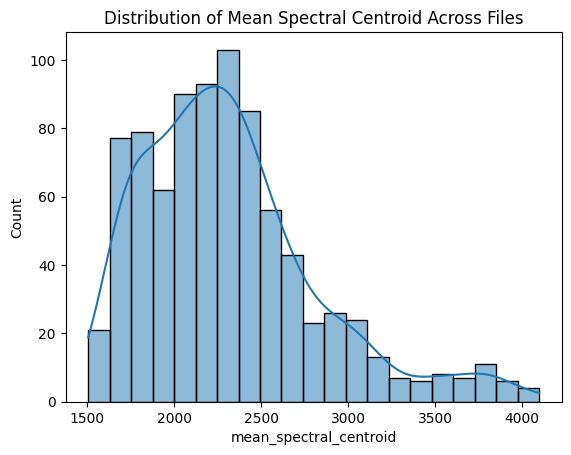

In [76]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


sns.histplot(df['mean_spectral_centroid'], kde=True)
plt.title("Distribution of Mean Spectral Centroid Across Files")
plt.show()

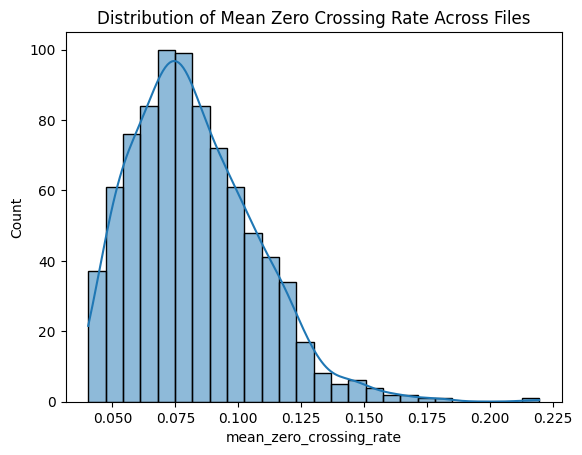

In [77]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


sns.histplot(df['mean_zero_crossing_rate'], kde=True)
plt.title("Distribution of Mean Zero Crossing Rate Across Files")
plt.show()

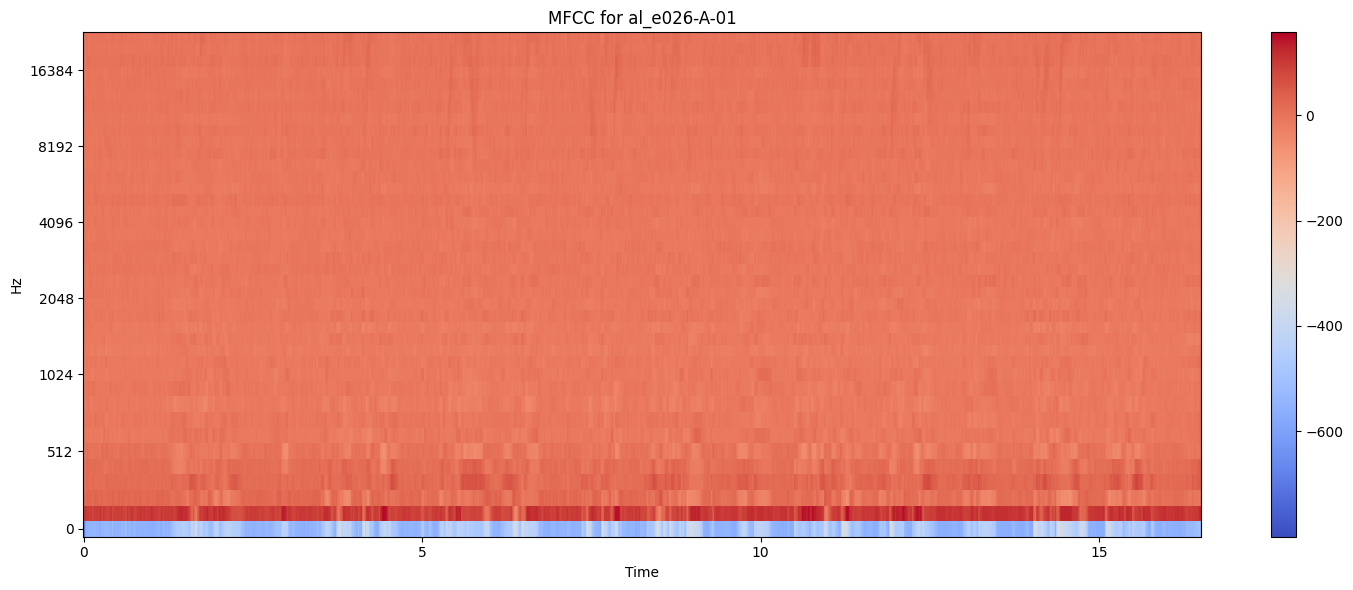

In [78]:
# Plot MFCCs
plt.figure(figsize=(15, 6))
librosa.display.specshow(df['mfcc'][0], sr=44100, x_axis='time', y_axis="mel")
plt.colorbar()
plt.title('MFCC for al_e026-A-01')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


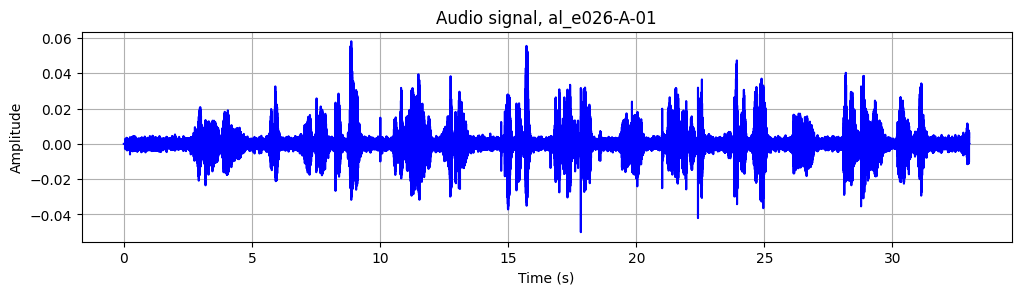

In [79]:
import numpy as np

waveform, sampling_rate = librosa.load(df['audio_path'][0])

plt.figure(figsize=(12, 6))

# Original waveform
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, len(waveform) / sampling_rate, num=len(waveform)), waveform, color='blue')
plt.title('Audio signal, al_e026-A-01')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

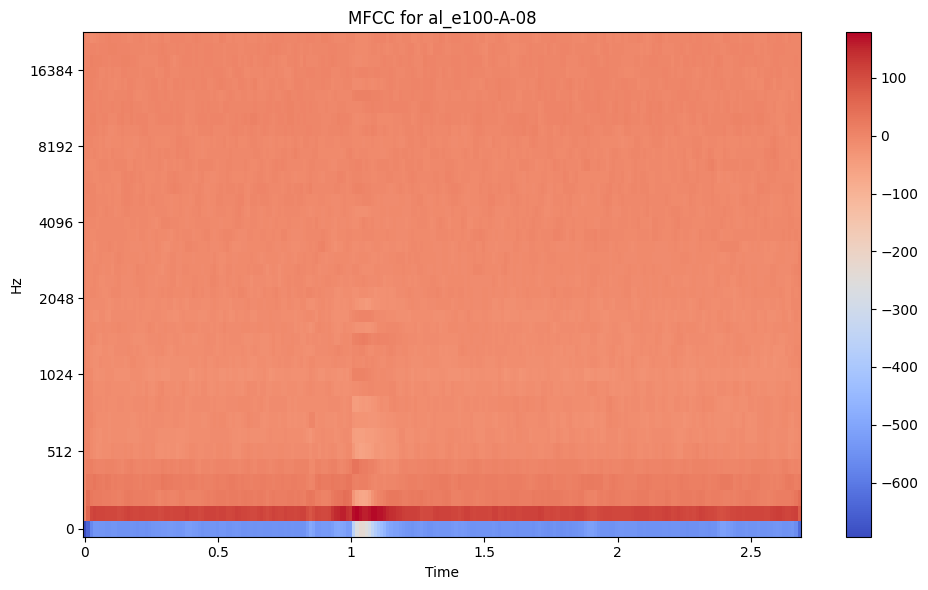

In [80]:
# Plot MFCCs
plt.figure(figsize=(10, 6))
librosa.display.specshow(df['mfcc'][333], sr=44100, x_axis='time', y_axis="mel")
plt.colorbar()
plt.title('MFCC for al_e100-A-08')
plt.tight_layout()
plt.show()

In [81]:
df['audio_path'][555]

'samples/audio/al_e117_A-32.m4a'

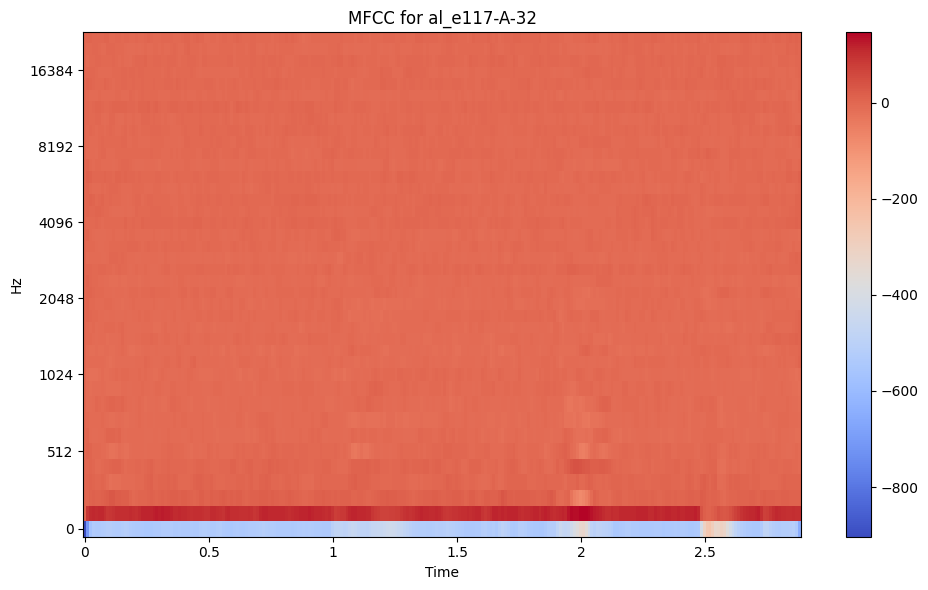

In [82]:
# Plot MFCCs
plt.figure(figsize=(10, 6))
librosa.display.specshow(df['mfcc'][555], sr=44100, x_axis='time', y_axis="mel")
plt.colorbar()
plt.title('MFCC for al_e117-A-32')
plt.tight_layout()
plt.show()

##### Observation

1. Dominant speech frequencies occur arround 200-250 Hz. 
    - This is where much of the energy from vowels and voiced speech sounds is concentrated.
2. Lighter red patches above 512 Hz
    - Some of these may be higher-frequency consonants (e.g., 's' or 'z'), but it could also indicate high-pitched background noise, perhaps from microphone hiss or environmental noise.

##### What needs to be done

1. Noise reduction
    - As we observed some high frequency noise throughout the audio files, we can use ***low-pass filters*** to remove frequencies above a certain threshold. (e.g., 3000 Hz)

#### 3.2 Applying a simple low-pass filter

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Picture No.              880 non-null    object 
 1   Original                 880 non-null    object 
 2   Edited                   880 non-null    object 
 3   patient                  880 non-null    object 
 4   audio_path               880 non-null    object 
 5   cleaned_original         880 non-null    object 
 6   cleaned_transcript       880 non-null    object 
 7   mean_amplitude           880 non-null    float32
 8   zero_crossing_rate       880 non-null    object 
 9   duration                 880 non-null    float64
 10  spectral_bandwidth       880 non-null    object 
 11  spectral_centroid        880 non-null    object 
 12  mfcc                     880 non-null    object 
 13  mean_zero_crossing_rate  880 non-null    float64
 14  mean_spectral_centroid   8

In [83]:
import numpy as np
import librosa
import soundfile as sf
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Load your audio file
audio_path = df['audio_path'][0]  # Replace with your audio file path
waveform, sampling_rate = librosa.load(audio_path, sr=None)

# Apply low-pass filter
cutoff_frequency = 300  # Set your desired cutoff frequency (in Hz)
filtered_waveform = lowpass_filter(waveform, cutoff=cutoff_frequency, fs=sampling_rate)

# Save the filtered audio to a new file
audio_path = Path(df['audio_path'][0]).stem

# New directory
export_dir = 'samples/audio_denoised/'
# Ensure the directory exists, create if necessary
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

processed_path = export_dir + audio_path + "_filtered.wav"

sf.write(processed_path, filtered_waveform, sampling_rate)

/usr/local/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


#### 3.3 Speechbrain Sepformer Library

SpeechBrain is an open-source, all-in-one toolkit designed for speech processing. Built on PyTorch, it offers a comprehensive suite of tools for a variety of speech-related tasks, including speech recognition, speaker identification, and speech enhancement.

In [84]:
from speechbrain.inference.separation import SepformerSeparation as separator
import torchaudio

from IPython.display import Audio

In [85]:
sepformer = separator.from_hparams(
    source="speechbrain/sepformer-wham16k-enhancement", 
    savedir='pretrained_models/sepformer-wham16k-enhancement',
    run_opts={"device":"cuda"}
)

hyperparams.yaml:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

decoder.ckpt:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

/usr/local/lib/python3.8/site-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)

In [94]:
from pathlib import Path

In [60]:
import gc
from speechbrain.inference.separation import SepformerSeparation
import librosa
import noisereduce as nr
import soundfile as sf

def denoise(audio_file_path: str, denoiser=None):
    """ A function that denoises an audio and writes it to 
        a new directory

        Args: 
            audio_file_path - File path to the target audio
            denoiser - The denoiser model
    """
    export_dir = 'samples/audio_denoised'
    # Ensure the directory exists, create if necessary
    if not os.path.exists(export_dir):
        os.makedirs(export_dir)
    
    if isinstance(denoiser, SepformerSeparation):
        audio_tensor = denoiser.separate_file(path=audio_file_path)
        audio_tensor = audio_tensor.cpu()
        
        processed_path = Path(audio_file_path).stem
        new_path = f"{export_dir}/{processed_path}_mod.wav"
        torchaudio.save(new_path, audio_tensor[:, :, 0], 16000) 
        
        del audio_tensor
        gc.collect()
        torch.cuda.empty_cache()
    else:
        y, sr = librosa.load(audio_file_path, sr=44100)
        reduced_noise = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.75)
        new_path = f"{export_dir}/{Path(audio_file_path).stem}_filtered.wav"
        sf.write(new_path, reduced_noise, sr)
    
    return new_path

In [95]:
df_al_e026 = df.loc[df['patient'] == 'al_e026']

In [96]:
tqdm.pandas(desc="Denoising Files, al_e026")
df_al_e026['audio_path_denoised'] = df_al_e026.progress_apply(lambda row: denoise(row['audio_path'], sepformer), axis=1)

Denoising Files, al_e026:   0%|          | 0/33 [00:00<?, ?it/s]

Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling the audio from 44100 Hz to 16000 Hz
Resampling th

/tmp/ipykernel_249/2895497546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_al_e026['audio_path_denoised'] = df_al_e026.progress_apply(lambda row: denoise(row['audio_path'], sepformer), axis=1)


In [61]:
tqdm.pandas(desc="Transcribing and computing WER al_e026")
df_al_e026 = df_al_e026.progress_apply(lambda row: transcribe_and_compute(row, row['audio_path']), axis=1)

NameError: name 'df_al_e026' is not defined

In [98]:
tqdm.pandas(desc="Transcribing and computing WER al_e026 denoise")
df_al_e026 = df_al_e026.progress_apply(lambda row: transcribe_and_compute(row, row['audio_path_denoised'], True), axis=1)

Transcribing and computing WER al_e026 denoise:   0%|          | 0/33 [00:00<?, ?it/s]

In [99]:
df_al_e026['wer'] = df_al_e026['wer'].apply(lambda x: 1 if x > 1 else x)
df_al_e026['wer_denoise'] = df_al_e026['wer_denoise'].apply(lambda x: 1 if x > 1 else x)

print(f"WER (Original): {df_al_e026['wer'].mean()}")
print(f"WER (Denoise): {df_al_e026['wer_denoise'].mean()}")

WER (Original): 0.6287329270941688
WER (Denoise): 0.9096658949676684


This library does not do a good job in reducing the WER - in fact the opposite happened. We should explore other libraries. Here are the possible reasons:

1. The use of this algorithm necessitates the downsampling of the audio file from 44.1kHz to 16kHz, resulting in a huge loss in data.

##### 3.3 Noisereduce Library
We will now try another library for reducing background noise. Remember, we want to filter the higher frequency noise around 3000 Hz and above.

In [62]:
tqdm.pandas(desc="Denoising Files")
df['audio_path_denoised'] = df.progress_apply(lambda row: denoise(row['audio_path']), axis=1)

Denoising Files: 100%|██████████| 453/453 [04:08<00:00,  1.82it/s]


In [ ]:
tqdm.pandas(desc="Transcribing and computing WER prompt denoised")
df['whisper_transcription_prompt_denoised'] = df.progress_apply(
    lambda row: normalizer(transcribe_audio(row['audio_path_denoised'], model, input_prompt=f"The patient is supposed to say: '{row['cleaned_transcript']}.'")), axis=1
)

Transcribing and computing WER prompt denoised:  94%|█████████▎| 424/453 [04:54<00:20,  1.41it/s]

In [ ]:
# Replace empty transcriptions with "null"
df['whisper_transcription_prompt_denoised'] = df['whisper_transcription_prompt_denoised'].apply(lambda x: "null" if x == "" else normalizer(x.strip()))

df_with_prompt_denoised = df['whisper_transcription_prompt_denoised'].tolist()

hypo = df['cleaned_transcript'].apply(lambda x: x.strip()).tolist()

df.head(75)

In [56]:
count = 0
for item in df_with_prompt_denoised:
    if item == "null":
        count += 1
print(count)

6


In [57]:
wer_prompt = wer(df_with_prompt, hypo)
wer_prompt_denoised = wer(df_with_prompt_denoised, hypo)

print(f"Prompt WER (Overall): {wer_prompt}")
print(f"Prompt WER Denoised (Overall): {wer_prompt_denoised}")

Prompt WER (Overall): 0.5521235521235521
Prompt WER Denoised (Overall): 0.6033898305084746


In [58]:
wer_original = wer(df['whisper_transcription'].tolist(), hypo)

print(f"WER (Overall): {wer_original}")
print(f"Prompt WER (Overall): {wer_prompt}")
print(f"Prompt WER Denoised (Overall): {wer_prompt_denoised}")

WER (Overall): 0.831275720164609
Prompt WER (Overall): 0.5521235521235521
Prompt WER Denoised (Overall): 0.6033898305084746


#### Findings

| model              | temperature | prompt | dataset               | WER % (lower is better)|
|--------------------|-------------|--------|-----------------------|------------------------|
| `whisper-large-v3` | 0.0         |   no   | noun-en               | 83                     |
| `whisper-large-v3` | 0.0         |   yes  | noun-en               | 55                     |
| `whisper-large-v3` | 0.0         |   yes  | noun-en-denoise       | 60                     |

Overall, noise reduction techniques don't really have that much of an effect when it comes to WER (Based on eyeballing and hearing some post-processed samples, the noise reduction was done really well). We will now explore fine-tuning the model on the dataset. Refer to `whisper_fine_tune.ipynb` for details.